In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import pprint as pp
import matplotlib.pyplot as plt
import json
%matplotlib inline

import spacy
#nlp = spacy.load("nl_core_news_sm")
#from spacy.lang.nl import Dutch
import re

from coicop_preprocessing import CoicopPreprocessing

In [2]:
# Product frequencies gathered from previous runs from the @HBS app.
prods = pd.read_csv("coicop_data/productfrequenties.csv", delimiter=";", encoding = "ISO-8859-1", index_col=0).drop_duplicates()
prods["coicop_s"] = prods.index
prods["CoicopNr"] = prods.coicop_s.apply(CoicopPreprocessing.remove_dots)
prods.sort_values("code")

prods2 = prods[["CoicopNr", "product", "coicop"]].rename(columns={"product":"EanNaam", 
                                                                  "coicop":"CoicopNaam"})
prods_temp = prods2[["CoicopNr", "CoicopNaam"]].drop_duplicates()
prods_temp["EanNaam"] = prods_temp.CoicopNaam

prods = pd.concat([prods2, prods_temp]).drop("CoicopNaam", axis=1)

# Information from Albert Heijn about product descriptions compared to receipt descriptions.
ah_short_text = pd.read_csv("coicop_data/kassaomsch.csv", delimiter=";", encoding = "ISO-8859-1")
ah_short_text["OMSCH"] = ah_short_text.OMSCH.str.lower()
ah_short_text["KASSA"] = ah_short_text.KASSA.str.lower()
ah_short_text = ah_short_text.drop_duplicates()
ah_short_text

# A number of columns of the CPI data pertaining to product names and their COICOP codes.
coicop = pd.read_csv("coicop_data/Coicop_data.csv", delimiter=",", encoding = "ISO-8859-1", index_col=0)
coicop = coicop[~pd.isnull(coicop.EanNaam)]
coicop = coicop[~pd.isnull(coicop.CoicopNr)]
coicop["EanNaam"] = coicop.EanNaam.str.lower()

In [3]:
yes_coicop = coicop[~pd.isnull(coicop.CoicopNr)]
yes_coicop2 = yes_coicop.drop(["EsbaNr"], axis=1).drop_duplicates()

unique_coicops = pd.unique(yes_coicop.CoicopNaam)

coicop_distribution = Counter(yes_coicop2.CoicopNaam.tolist())

# ah_short_text does not have coicop codes.
# Attach known coicop codes to receipt descriptions of products.
coicop_short = yes_coicop2.merge(ah_short_text, left_on="EanNaam", right_on="OMSCH", how="inner")
coicop_short = coicop_short.drop(["EanNaam", "OMSCH"], axis=1).drop_duplicates()
coicop_short = coicop_short.rename(columns={"KASSA":"EanNaam"}).drop_duplicates()

# Added receipt descriptions of products to the dataset.
data = pd.concat([yes_coicop2, coicop_short])
data = data.drop_duplicates()
data["CoicopNr"] = data.CoicopNr.astype(int)

data = pd.concat([
    data, 
    prods.merge(data[["CoicopNr", "CoicopNaam"]].drop_duplicates(), how="left", on="CoicopNr").dropna()]).drop_duplicates()

data = CoicopPreprocessing.clean_receipt(data, "EanNaam")
data["EanToken"] = data.EanNaam.apply(CoicopPreprocessing.tokenizer)

In [4]:
# necessary since for example numbers and common words are removed
data = data.reset_index(drop=True)
data = CoicopPreprocessing.clean_receipt(data, "EanToken")
data.head()

/home/gebruiker/Documents/kassabonnen/hbs.wp4-shopping-receipt-recognition/coicop_preprocessing.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].str.lower()


CoicopNr                                         CoicopNaam  \
0     11360  Overige bereidingen en conserven van vis en sc...   
1     11150                                    Pizza en quiche   
2     21210                                   Wijn van druiven   
3    121320  Artikelen voor persoonlijke hygiëne en wellnes...   
4     11730  Gedroogde groenten, andere bereidingen en cons...   

                     EanNaam                   EanToken  
0  grillc portie gebakken le  grillc portie gebakken le  
1      jumbo tiu pizza hawai            tiu pizza hawai  
2         les ma st saturnin         les ma st saturnin  
3  guhl colormousse 70 blond     guhl colormousse blond  
4         kuhne cocktail mix         kuhne cocktail mix

In [81]:
data['EanToken'].head(20)

0          grillc portie gebakken le
1                    tiu pizza hawai
2                 les ma st saturnin
3             guhl colormousse blond
4                 kuhne cocktail mix
5          dove deorol fm clean comf
6     robins sinaasappel unit_liquid
7                   smarti sneeuwman
8            mentos blackmint bottle
9              mentos pepmint bottle
10                  taft gel fix str
11              kent hd white infina
12       johma zalmsalade unit_solid
13              pallma myo volum red
14         belind belinda filter kin
15           kroon saks bol likkepot
16          verste weck steranijs hl
17                  ches classic red
18              pallma shag full flv
19                    lucky shag vol
Name: EanToken, dtype: object

In [5]:
# check if cleaning worked
data.isna().sum()

CoicopNr      0
CoicopNaam    0
EanNaam       0
EanToken      0
dtype: int64

## Removing "Overig" categories when possible 
This dataset also contains a lot of duplicate product names with different COICOP codes.
If you provide 1 entry with 2 possible answers, the algorithm will also end up making at least 1 mistake.
If a product has a less generic option, we remove the "Overig" option.

In [6]:
print("Data before", len(data))
duplicated = list(set(data.EanToken[data.EanToken.duplicated()].to_list()))
print("Dups", len(duplicated))
for dup in duplicated:
    d = data[data.EanToken == dup]
    overig = d.CoicopNaam.str.contains("Overig")
    if any(overig) and not all(overig):
        data = data.drop(d[overig].index)
data = data.dropna()
print("Data after", len(data))

Data before 288806
Dups 18169
Data after 285937


## Save to .csv

In [7]:
data.to_csv("coicop_input/data_preprocessed.csv")
data[["EanToken", "CoicopNaam"]].to_csv("coicop_input/data_preprocessed_onlyToken_Coicop.csv", index=False)
data[["EanToken", "CoicopNr"]].to_csv("coicop_input/data_preprocessed_onlyToken_CoicopNr.csv", index=False)


## Plot distribution

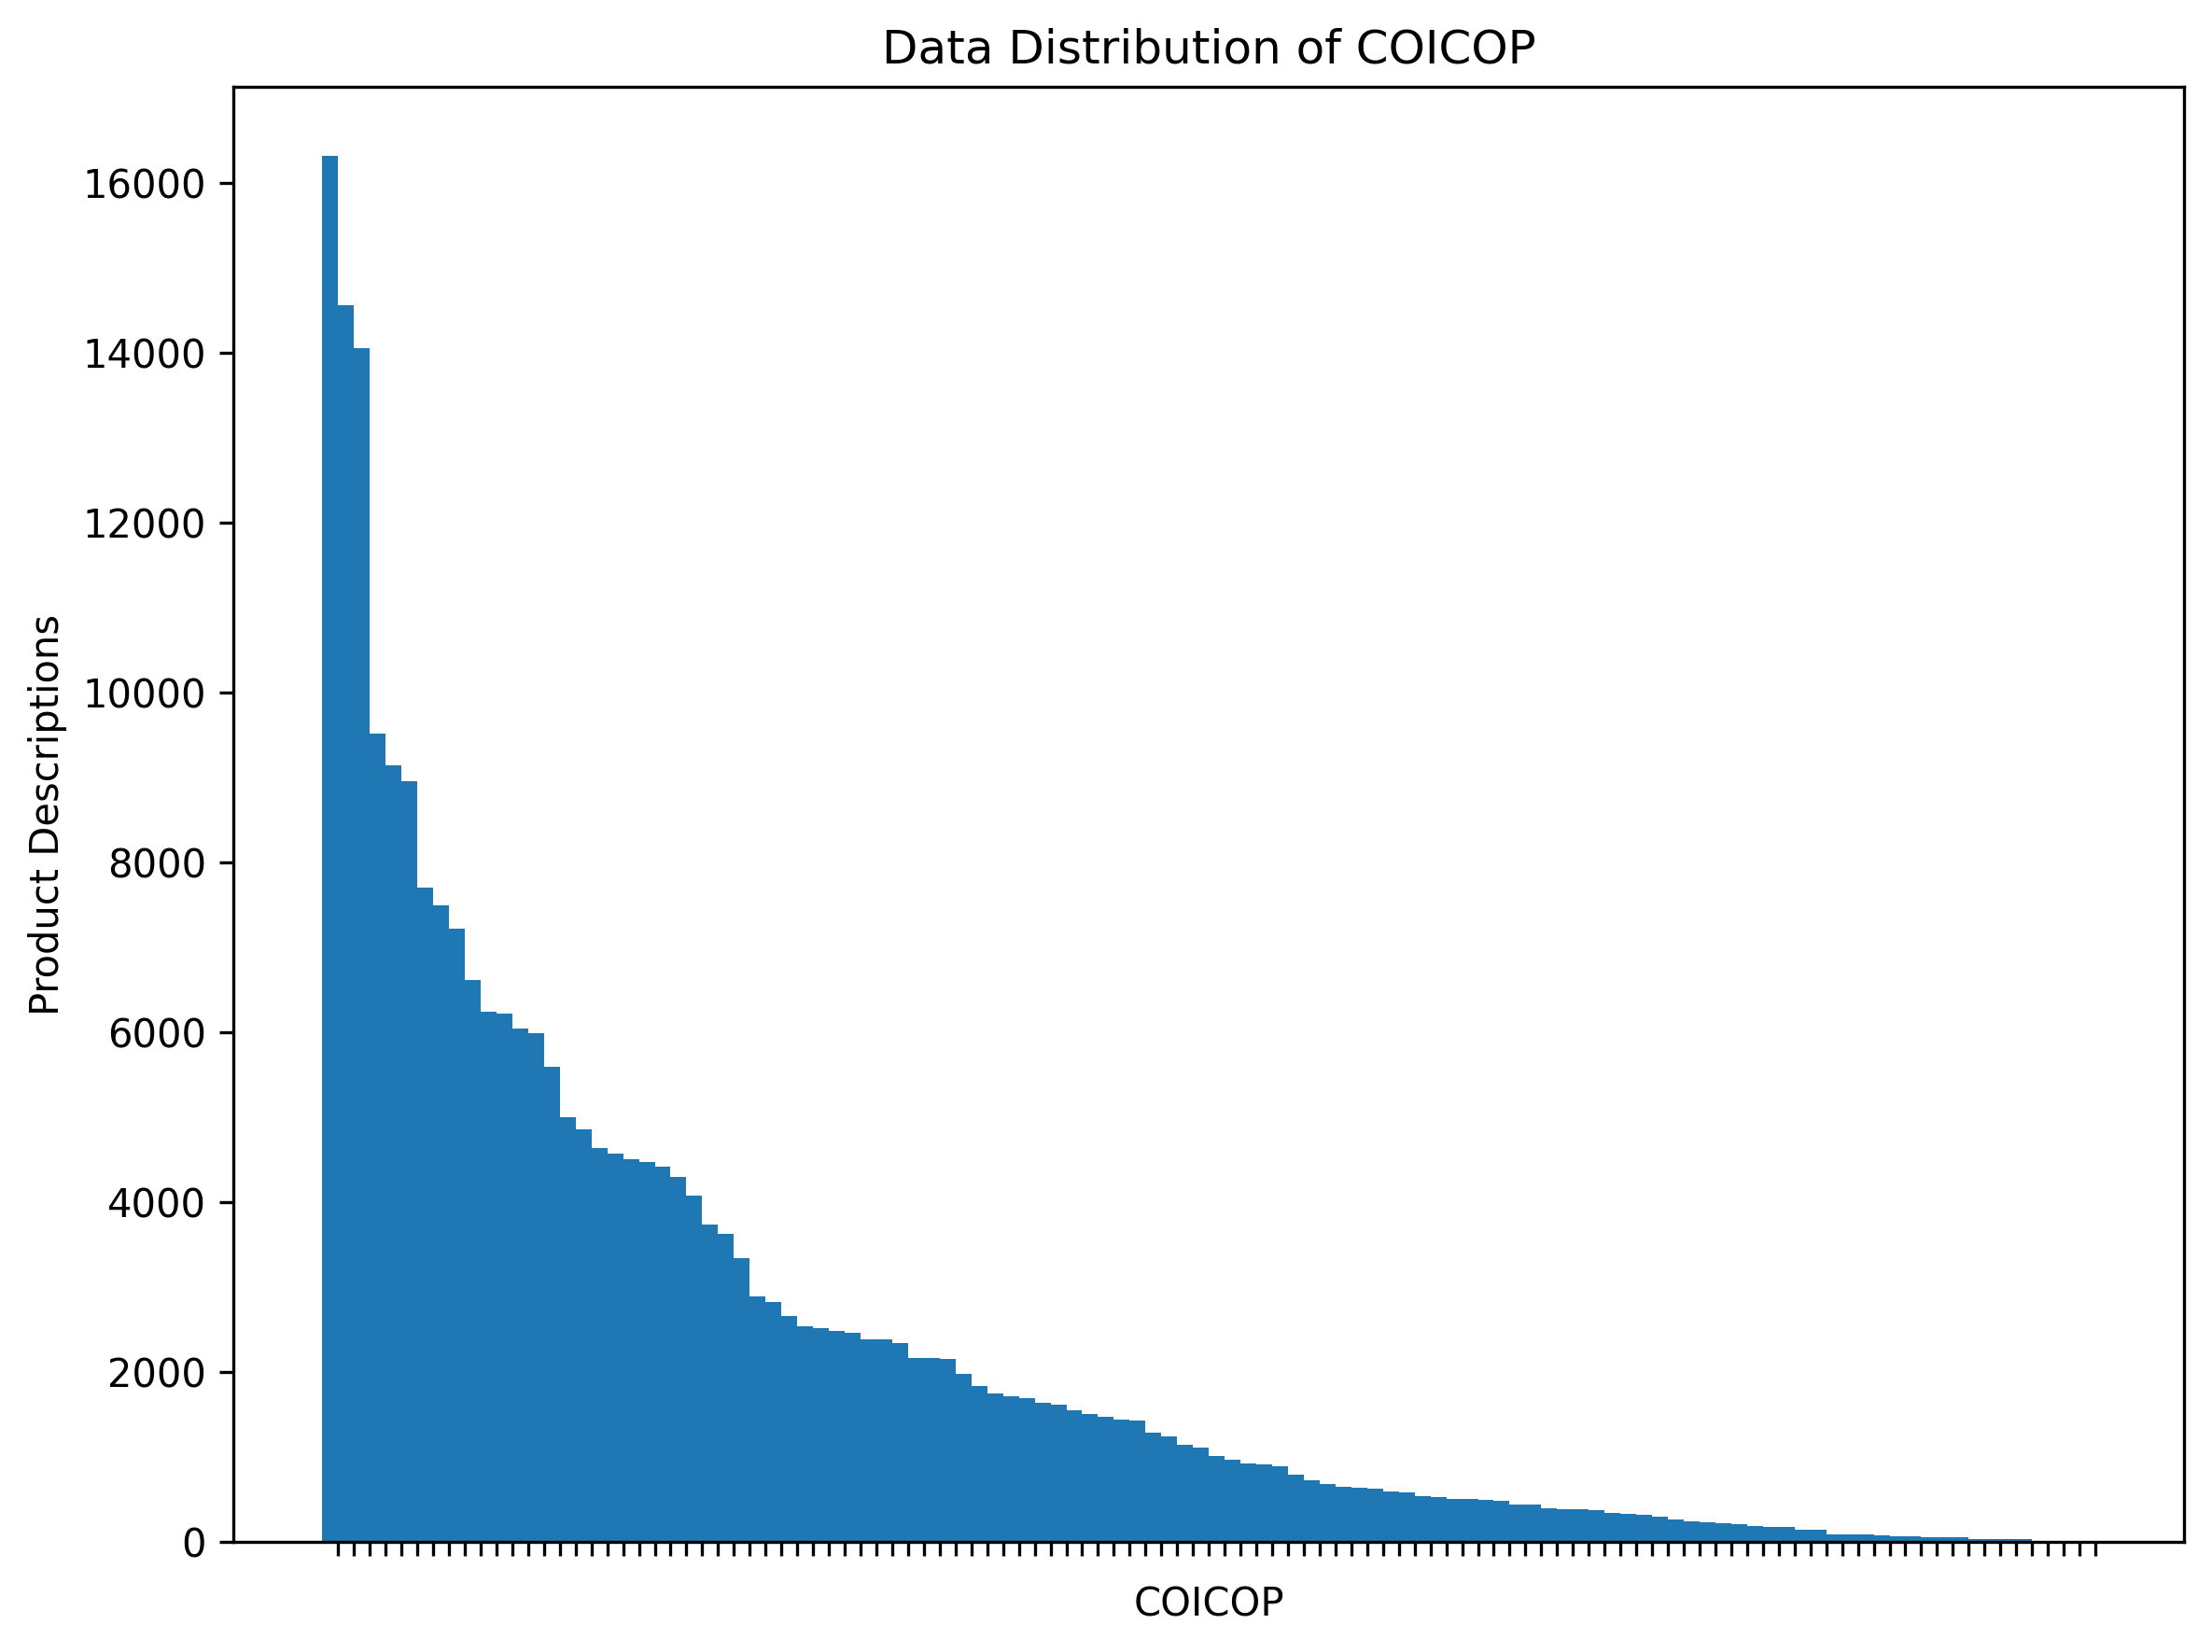

In [7]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

labels, values = zip(*coicop_distribution.most_common())

indexes = np.arange(len(labels))
width = 1
fig = plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.bar(indexes, values, width)
plt.title("Data Distribution of COICOP")
plt.ylabel("Product Descriptions")
plt.xlabel("COICOP")
plt.xticks(indexes + width * 0.5, ["" for x in range(len(labels))], rotation=90)
#plt.show()
fig.tight_layout()
plt.savefig('coicop_output/distribution.png')

In [78]:
# least frequent labels
freq = list(zip(labels, values))
df_freq = pd.DataFrame(freq, columns = ['Label', 'Number'])
# df_freq = df_freq.loc[df_freq['Number'] < 100, ]

# add name
df_freq = pd.merge(df_freq, yes_coicop[['CoicopNaam', 'CoicopNr']].drop_duplicates(), how='left', 
                   left_on='Label', right_on='CoicopNaam')
df_freq.drop(columns = ['CoicopNaam'], inplace=True)
df_freq['coicopNr_prep'] = df_freq['CoicopNr'].astype(int).astype(str).str[:-1].str[:5]


# products that do not occur at list
all_coicop = pd.read_excel("coicop_data/TFQI18-2020-06 Annex - COICOP 2018-ECOICOP.xlsx") # COICOP_2018.xlsx")
all_coicop['code'] = all_coicop['COICOP 2018'].str.replace('\.','').str[1:]
all_coicop = all_coicop.loc[all_coicop['COICOP 2018 level'] >= 5] # according to data

df_freq = pd.merge(df_freq, all_coicop[['COICOP 2018 level', 'COICOP 2018 HEADING', 'code']].drop_duplicates(), how='outer', 
                   left_on='coicopNr_prep', right_on='code')
print(df_freq.head(5))

df_freq.to_csv('coicop_output/product_frequency.csv')


                                               Label   Number  CoicopNr  \
0  Artikelen voor persoonlijke hygiëne en wellnes...  16312.0  121320.0   
1                    Overige voedingsmiddelen n.e.g.  14557.0   11990.0   
2                          Overige bakkerijproducten  14050.0   11140.0   
3                 Schoonmaak- en onderhoudsproducten   9514.0   56110.0   
4                            Kant-en-klaarmaaltijden   9146.0   11940.0   

  coicopNr_prep  COICOP 2018 level  \
0         12132                NaN   
1          1199                5.0   
2          1114                5.0   
3          5611                5.0   
4          1194                5.0   

                                COICOP 2018 HEADING  code  
0                                               NaN   NaN  
1                   Other food products n.e.c. (ND)  1199  
2                            Breakfast cereals (ND)  1114  
3  Household cleaning and maintenance products (ND)  5611  
4             Spices

In [80]:
df_freq.iloc[0]

Label                  Artikelen voor persoonlijke hygiëne en wellnes...
Number                                                             16312
CoicopNr                                                          121320
coicopNr_prep                                                      12132
COICOP 2018 level                                                    NaN
COICOP 2018 HEADING                                                  NaN
code                                                                 NaN
Name: 0, dtype: object

In [51]:
all_coicop = pd.read_excel("coicop_data/COICOP_2018.xlsx")
all_coicop['code'] = all_coicop['CODE'].str.replace('\.','').str[1:]
print(all_coicop.dtypes)
# all_coicop.iloc[0][['CODE', 'code']]
all_coicop.head(20)

ID                     int64
CODE                  object
LEVEL                  int64
HEADING               object
INTRODUCTORY NOTES    object
INCLUDES              object
INCLUDES ALSO         object
EXCLUDES              object
code                  object
dtype: object


ID      CODE  LEVEL                                            HEADING  \
0    1        01      1                   FOOD AND NON-ALCOHOLIC BEVERAGES   
1    2      01.1      2                                               FOOD   
2    3    01.1.1      3                   Cereals and cereal products (ND)   
3    4  01.1.1.1      4                                       Cereals (ND)   
4    5  01.1.1.2      4                              Flour of cereals (ND)   
5    6  01.1.1.3      4                     Bread and bakery products (ND)   
6    7  01.1.1.4      4                             Breakfast cereals (ND)   
7    8  01.1.1.5      4  Macaroni, noodles, couscous and similar pasta ...   
8    9  01.1.1.9      4          Other cereal and grain mill products (ND)   
9   10    01.1.2      3  Live animals, meat and other parts of slaughte...   
10  11  01.1.2.1      4                             Live land animals (ND)   
11  12  01.1.2.2      4                Meat, fresh, chilled or frozen (ND)   
12  13  01.1.2.3      4       Meat, dried, salted, in brine or smoked (ND)   
13  14  01.1.2.4      4  Offal, blood and other parts of slaughtered an...   
14  15  01.1.2.5      4  Meat, offal, blood and other parts of slaughte...   
15  16    01.1.3      3                        Fish and other seafood (ND)   
16  17  01.1.3.1      4          Fish, live, fresh, chilled or frozen (ND)   
17  18  01.1.3.2      4       Fish, dried, salted, in brine or smoked (ND)   
18  19  01.1.3.3      4                             Fish preparations (ND)   
19  20  01.1.3.4      4  Other seafood, live, fresh, chilled or frozen ...   

                                   INTRODUCTORY NOTES  \
0   Division 01 covers food (01.1) and non-alcohol...   
1   Food purchased by the household mainly for con...   
2                                                 NaN   
3   Dried grains of cereals, whether or not broken...   
4   Flour of cereals mentioned in Subclass 01.1.1....   
5                                                 NaN   
6                                                 NaN   
7                                                 NaN   
8                                                 NaN   
9                                                 NaN   
10  Live land animals, both domestic and wild, for...   
11  Meat of all animals, both domestic and wild, f...   
12  Meat of all animals, dried, salted, in brine o...   
13  Offal and other parts of slaughtered animals, ...   
14  Meat, offal or blood preparations, whether fro...   
15  Fish and other seafood, harvested or farmed in...   
16              Fish, live, fresh, chilled or frozen.   
17           Fish, dried, salted or in brine; smoked.   
18  Prepared foodstuffs made of fish, whether froz...   
19                                                NaN   

                                             INCLUDES  \
0                                                 NaN   
1   - products that need to be cooked and further ...   
2                                                 NaN   
3   - wheat;\r\n- rice, including parboiled rice;\...   
4   - flour of cereals mentioned in Subclass 01.1....   
5   - bread and bread rolls;\r\n- crisp bread, rus...   
6   - cornflakes, oatmeal and oat flakes, muesli, ...   
7   - pasta uncooked, whether stuffed or not, and ...   
8   - mixes and doughs for the preparation of bake...   
9                                                 NaN   
10  - cattle (cow, veal, common ox, zebu or humped...   
11  - meat of cattle (cow, veal, common ox, zebu o...   
12                              - bacon, ham, salami.   
13  - bones;\r\n- pork heads, tails and ears; chic...   
14  - sausages and similar products of meat, offal...   
15  - aquatic turtles;\r\n- other edible aquatic i...   
16  - fish, live for food purpose;\r\n- fish, fres...   
17  - fish fillets and meat, dried, salted or in b...   
18  - fillets merely covered with batter or bread ...   
19  - crabs, lobsters, cray

In [ ]:
## (tmp) coicops without data

print(yes_coicop2.head())

# ah_short_text does not have coicop codes.
# Attach known coicop codes to receipt descriptions of products.
coicop_all = yes_coicop2.merge(ah_short_text, left_on="EanNaam", right_on="OMSCH", how="outer")

## Split into train/validation-set and test-set
The dataset is split into 2 sets such that a test set is kept seperately.
The train/validation-set can then either be used using cross-fold validation or just a normal train/validation split



In [11]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(data.EanToken,
                                                   data.CoicopNr,
                                                   test_size = 0.1,
                                                   shuffle=True,
                                                   stratify=data.CoicopNaam,
                                                   random_state = 1)
train_val_pd = pd.DataFrame()
train_val_pd["input"] = train_x
train_val_pd["output"] = train_y
train_val_pd.to_csv("coicop_input/train_val_set.csv", index=False)

test_pd = pd.DataFrame()
test_pd["input"] = test_x
test_pd["output"] = test_y
test_pd.to_csv("coicop_input/test.csv", index=False)